# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World


## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [2]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`. 

In [3]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned
        


Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: north
step 1 - action: suck
step 2 - action: north
step 3 - action: east
step 4 - action: west
step 5 - action: south
step 6 - action: north
step 7 - action: west
step 8 - action: north
step 9 - action: north
step 10 - action: west
step 11 - action: west
step 12 - action: north
step 13 - action: east
step 14 - action: east
step 15 - action: north
step 16 - action: south
step 17 - action: north
step 18 - action: east
step 19 - action: east


1

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environmnt for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [5]:
def print_room(room,bot_x=None,bot_y=None):
    for i in range(len(room)):
        for j in range(len(room[i])):
            _end = "  "
            if room[i][j] == -1:
                _end = " "
            
            if(i == bot_y and j == bot_x):
                print("X",end=_end)
                continue
            print(room[i][j], end=_end)
        print("")
    print("")

In [6]:
def make_dirty(room,dirt_probability=0.2):
    rng = np.random.default_rng()
    
    
    for i in range(len(room)):
        for j in range(len(room[i])):
            randVal = rng.random()
            if randVal <= dirt_probability:
                room[i][j] = 1

    return room

In [7]:
def calc_bot_status(room,bot_x,bot_y):
    dirty = False
    if(room[bot_y,bot_x] == 1):
        dirty = True
    bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}
    
    if(bot_y == len(room) -1):
        bumpers["south"] = True
    elif(room[bot_y + 1, bot_x] == -1):
        bumpers["south"] = True
    if(bot_y == 0):
        bumpers["north"] = True
    elif(room[bot_y - 1, bot_x] == -1):
        bumpers["north"] = True
    if(bot_x == len(room[bot_y])-1):
        bumpers["east"] = True
    elif(room[bot_y,bot_x + 1] == -1):
        bumpers["east"] = True
    if(bot_x == 0):
        bumpers["west"] = True
    elif(room[bot_y,bot_x -1] == -1):
        bumpers["west"] = True
    
    return bumpers,dirty


In [8]:
def add_walls(room, wall_percentage):
    rng = np.random.default_rng()
    
    
    for i in range(len(room)):
        for j in range(len(room[i])):
            randVal = rng.random()
            if randVal <= wall_percentage:
                room[i][j] = -1
    return room

In [9]:
def advanced_environment(agent,max_steps, verbose=True, grid=None,grid_height=5,grid_width=5,wall_percentage=0.0):
    
    room = []
    if(not grid is None):
        room=grid
    else:
        room = np.zeros((grid_height,grid_width),dtype=int)
        
    room = make_dirty(room,dirt_probability=0.20)
    room = add_walls(room,wall_percentage)
    num_dirty = 0
    for i in range(len(room)):
        for j in range(len(room[i])):
            if room[i][j] == 1:
                num_dirty += 1
    num_steps = 0
    
    rng = np.random.default_rng()
    bot_x = rng.choice(range(grid_width))
    bot_y = rng.choice(range(grid_height))
    
    while(room[bot_y][bot_x] == -1):
        bot_x = rng.choice(range(grid_width))
        bot_y = rng.choice(range(grid_height))
        
    if verbose:
        print("Initial Room layout")
        print_room(room,bot_x,bot_y)
    
    for i in range(max_steps):
        if(num_dirty == 0):
            if(verbose):
                print("Completed in",num_steps,"steps!")
            break
        bumpers,dirty = calc_bot_status(room,bot_x,bot_y)
        
        action = agent(bumpers,dirty)
        if(verbose):
            print("step",num_steps,"- action:",action)
        
        if(action == "suck"):
            if(room[bot_y,bot_x] == 1):
                num_dirty -= 1
                room[bot_y,bot_x] = 0
            else:
                if(verbose):
                    print("You cleaned a clean tile!")
        elif(action == "north"):
            if(not bumpers["north"]):
                bot_y -= 1
            else:
                if(verbose):
                    print("You bumped into a wall moving North!")
        elif(action == "south"):
            if(not bumpers["south"]):
                bot_y += 1 
            else:
                if(verbose):
                    print("You bumped into a wall moving South!")
        elif(action == "east"):
            if(not bumpers["east"]):
                bot_x += 1
            else:
                if(verbose):
                    print("You bumped into a wall moving East!")
        elif(action == "west"):
            if(not bumpers["west"]):
                bot_x -= 1
            else:
                if(verbose):
                    print("You bumped into a wall moving West!")
        else:
            print("INVALID AGENT ACTION:",action)
            break
        
        if(verbose):
            print_room(room,bot_x,bot_y)
            
            
        num_steps +=1
    return num_steps,num_dirty



In [10]:
num_steps,num_dirty = advanced_environment(simple_randomized_agent,max_steps=1000,verbose=False)
print("Total Number of steps:",num_steps,"\nWith",num_dirty," tiles still dirty!")

Total Number of steps: 1000 
With 1  tiles still dirty!


## Task 2:  Implement a simple reflex agent [10 Points] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [11]:
# Your code and description goes here
def reflex_agent(bumpers, dirty):
    if(dirty):
        return "suck"
    actions = []
    rng = np.random.default_rng()
    for val in bumpers:
        if(not bumpers[val]):
            actions.append(val)
    return rng.choice(actions)
    
num_steps,num_dirty = advanced_environment(reflex_agent,max_steps=100,verbose=False)
print("Total Number of steps:",num_steps,"\nWith",num_dirty," tiles still dirty!")
    

Total Number of steps: 100 
With 1  tiles still dirty!


## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb))

### Overview
The way that my agent works is by keeping a local coordinate map of all of the tiles that it has encountered and storing that in memory. The agent will look at it's bumper sensors and determine if the squares around it are walls or not. It will then choose the first square that is not a wall and is not clean and navigate to it by traveling in a straight line in the x axis and then a straight line in the y axis (It moves like a knight in chess, the L shaped path). As the agent is traveling, it will clean any dirty square and mark any square it has passed over as clean in memory. This process is then repeated until there are no unknown squares left in the agent's memory.

### Implementation
#### Coordinate Class
The first step to creating this agent was to create a custom `Coordinate` class. This class just wraps an x position, y position, and a cost. The cost of a square can be calculated by using the pythagorean theorem to get the distance as the crow flies from any `Coordinate` to the current `Coordinate`. While I did not get to fully utilize the cost value here, it can be used to perform an A* pathfinding algorithm instead of the L shaped movement that is currently implemented.

#### Model Agent Class
This class is where all of the major logic is performed. Firstly, there is a `calc_path()` function that will take in a `Coordinate` object and return a list of `Coordinates` to move to in order get to that `Coordinate`. This is done by finding the different states that lead to our goal state (the passed in `Coordinate` object).

Secondly, there is a `move_one_square()` function that takes in a `Coordinate` object that is adjacent to the agent's current location and converts it into one of the valid actions (`north`,`east`,`south`,`west`). The purpose of this funciton is to make sure that I am able to convert from the agent states to valid actions.

Thirdly, there is a `agent_function()` where all of the major logic of the agent is. This function is what the `advanced_environment()` will call repeatedly to figure out what action the agent wants to take. Initially, the function checks to see if the current location of the agent is dirty, if it is it will return `suck` if it is not, then the function will set the current `Coordinate` to clean in memory and check to see if it has any queued up moves. If the agent has queued up moves, then it will return the next move in it's queue and pop off that move. If there are no queued up actions, the agent will begin to look at the bumper sensors. Based on the values of the bumper sensors, the agent will either populate it's local memory with a `Coordinate` that is a wall or a `Coordinate` that is unknown. The last step is to choose the first unknown `Coordinate` in it's memory and call the `calc_path()` function and store it's result in the queue.

In [12]:
class Coordinate:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.cost = 0
    def __eq__(self,other):
        return self.x == other.x and self.y == other.y
    def __lt__(self,other):
        return self.cost < other.cost
    def __gt__(self,other):
        return self.cost > other.cost
    def __le__(self,other):
        return self.cost <= other.cost
    def __ge__(self,other):
        return self.cost >= other.cost
    def __ne__(self,other):
        return self.x != other.x or self.y != other.y
    def __str__(self):
        return f"{self.x},{self.y}"
    def __hash__(self):
        return hash((self.x,self.y))
    def calculateCost(self,x:int,y:int):
        self.cost = (self.x-x)**2 + abs(self.y - y)**2
        return self.cost
    def calculateCost(self,coord):
        self.cost = (self.x-coord.x)**2 + (self.y - coord.y)**2
        return self.cost
    def set_type(self,_type):
        self.type = _type
        
    def __add__(self,rhs):
        return rhs.x+self.x, rhs.y+self.y
    
    def __sub__(self,rhs):
        return rhs.x-self.x, rhs.y-self.y

In [13]:
# Your short description of the state and your implementation goes here
# Uses 

class model_agent:
    
    def __init__(self):
        self.memory = {}
        self.location = Coordinate(0,0)
        self.currPath = []
    def calc_path(self,coordinateToMove:Coordinate):
        x_diff,y_diff = self.location - coordinateToMove
        #TODO Add a* pathfinding to this to create the currPath variable.

        x_step = 1
        y_step = 1
        if x_diff < 0:
            x_step = -1
        if y_diff < 0:
            y_step = -1
        for i in range(self.location.x,coordinateToMove.x + x_step,x_step):
            if( i == self.location.x):
                continue
            
            self.currPath.append(Coordinate(i,self.location.y))
        for i in range(self.location.y,coordinateToMove.y + y_step,y_step):
            if i == self.location.y:
                continue
            self.currPath.append(Coordinate(coordinateToMove.x,i))
    def move_one_square(self,whereToMove:Coordinate):
        x_diff,y_diff = self.location - whereToMove
        self.location = whereToMove
        if(x_diff > 0):
            return 'east'
        elif(x_diff < 0):
            return 'west'
        elif(y_diff > 0):
            return 'north'
        elif(y_diff < 0):
            return 'south'
        elif(self.location == whereToMove):
            return {'status':'invalid move'}
        else:
            return {'status':'invalid'}
    def agent_function(self,bumpers,dirty):
        if(dirty):
            return "suck"
        else:
            self.memory[self.location] = 'clean'
        
        

        if(bumpers['north']):
            self.memory[Coordinate(self.location.x,self.location.y + 1)] ='wall'
        elif(not Coordinate(self.location.x,self.location.y + 1) in self.memory):
             self.memory[Coordinate(self.location.x,self.location.y + 1)] = 'unknown'
        if(bumpers['south']):
            self.memory[Coordinate(self.location.x,self.location.y - 1)]='wall'
        elif(not Coordinate(self.location.x,self.location.y - 1) in self.memory):
             self.memory[Coordinate(self.location.x,self.location.y - 1)] = 'unknown'
        if(bumpers['east']):
            self.memory[Coordinate(self.location.x + 1,self.location.y)] ='wall'
        elif(not Coordinate(self.location.x + 1,self.location.y) in self.memory):
             self.memory[Coordinate(self.location.x + 1,self.location.y)] = 'unknown'
        if(bumpers['west']):
            self.memory[Coordinate(self.location.x - 1,self.location.y)] ='wall'
        elif(not Coordinate(self.location.x - 1,self.location.y) in self.memory):
             self.memory[Coordinate(self.location.x - 1,self.location.y)] = 'unknown'
                

        if(len(self.currPath) == 0):
            for i in self.memory:

                if self.memory[i] == 'unknown':
                    self.calc_path(i)
                    break
        
        if(len(self.currPath) != 0):
            nextMove = self.currPath[0]
            self.currPath.pop(0)
            return self.move_one_square(nextMove)

        
        
a = model_agent()


num_steps,num_dirty = advanced_environment(a.agent_function,max_steps=1000,verbose=False,grid_height=10,grid_width=10)
print("Total Number of steps:",num_steps,"\nWith",num_dirty," tiles still dirty!")

Total Number of steps: 220 
With 0  tiles still dirty!


## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents. 
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/charts_and_tables.ipynb))

In [14]:
# Your code goes here
import pandas as pd
n_max = 100
room_sizes = [5,10,20]

# num_steps,num_dirty = advanced_environment(a.agent_function,max_steps=100,verbose=False)
# print("Total Number of steps:",num_steps,"\nWith",num_dirty," tiles still dirty!")

# show data as a data frame using pandas
# df = pd.DataFrame(columns=['Randomized Agent','Simple Reflex Agent','Model Based Agent'])

frames = []

times = {
    'Random Agent':[],
    'Simple Reflex Agent':[],
    'Model Based Agent':[]
}

for size in room_sizes:
    
    for i in range(n_max):
        m_agent = model_agent()
        m_steps,m_dirty = advanced_environment(m_agent.agent_function,
                                               max_steps=10000,verbose=False,grid_height = size, grid_width = size)
        
        re_steps,re_dirty = advanced_environment(reflex_agent,
                                               max_steps=10000,verbose=False,grid_height = size, grid_width = size)
        
        ra_steps,ra_dirty = advanced_environment(simple_randomized_agent,
                                               max_steps=10000,verbose=False,grid_height = size, grid_width = size)
        times['Random Agent'].append(ra_steps)
        times['Simple Reflex Agent'].append(re_steps)
        times['Model Based Agent'].append(m_steps)
    
    frames.append(pd.DataFrame(times))
    for agent in times:
        times[agent].clear()

print("\t\t\t5x5 Grid")
print(frames[0])

print("\t\t\t10x10 Grid")
print(frames[1])

print("\t\t\t25x25 Grid")
print(frames[2])

print(f"5x5\tModel: {frames[0]['Model Based Agent'].mean()}\tSimple:{frames[0]['Simple Reflex Agent'].mean()}\tRandom: {frames[0]['Random Agent'].mean()}")
print(f"10x10\tModel: {frames[1]['Model Based Agent'].mean()}\tSimple:{frames[1]['Simple Reflex Agent'].mean()}\tRandom: {frames[1]['Random Agent'].mean()}")
print(f"20x20\tModel: {frames[2]['Model Based Agent'].mean()}\tSimple:{frames[2]['Simple Reflex Agent'].mean()}\tRandom: {frames[2]['Random Agent'].mean()}")

			5x5 Grid
    Random Agent  Simple Reflex Agent  Model Based Agent
0             43                  119                 48
1            926                   42                 52
2            773                  404                 31
3            531                   96                 40
4            338                  115                 44
..           ...                  ...                ...
95           137                   22                 24
96           615                  291                 43
97           250                  121                 32
98           175                  340                 36
99           302                   50                 55

[100 rows x 3 columns]
			10x10 Grid
    Random Agent  Simple Reflex Agent  Model Based Agent
0           3094                 1264                177
1           3394                  728                236
2           2307                  684                202
3           4113                 1112 

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |427.5 |105.45 |39.42 |
| 10x10   |2913.4 |948.18 |202.82 |
| 25x25 |10000.0 |5997.82 |888.2 |

Add charts to compare the performance of the different agents.

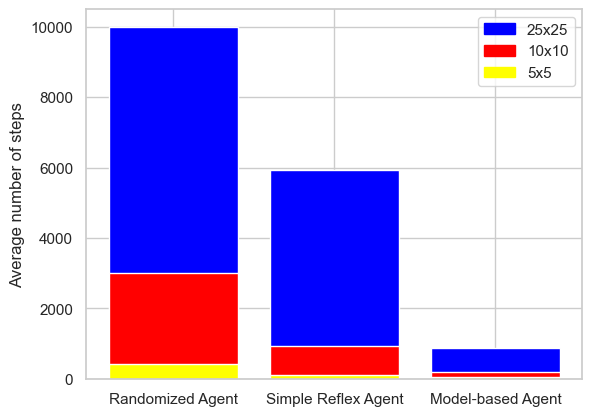

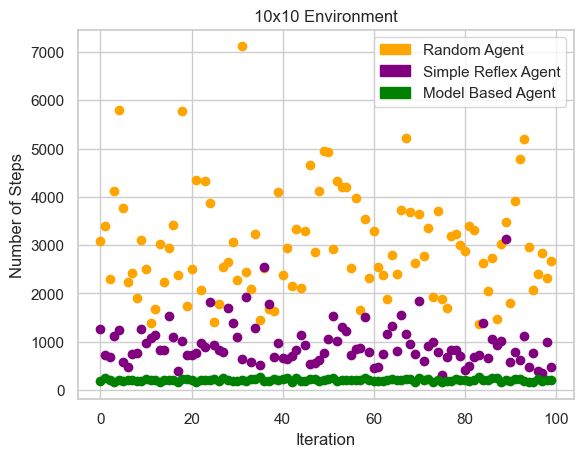

In [15]:
# Your graphs and discussion of the results goes here
import matplotlib.pyplot as plt

# add a grid to the plots
import seaborn as sns 
sns.set(style="whitegrid")

colors_sizes = {'25x25':'blue','10x10':'red','5x5':'yellow'}
colors_agents = {'Random Agent':'orange','Simple Reflex Agent':'purple','Model Based Agent':'green'}

plt.bar(['Randomized Agent','Simple Reflex Agent','Model-based Agent'], [frames[2]['Random Agent'].mean(),
                                                                               frames[2]['Simple Reflex Agent'].mean(),
                                                                               frames[2]['Model Based Agent'].mean()],
       color=colors_sizes['25x25'])
plt.bar(['Randomized Agent','Simple Reflex Agent','Model-based Agent'], [frames[1]['Random Agent'].mean(),
                                                                               frames[1]['Simple Reflex Agent'].mean(),
                                                                               frames[1]['Model Based Agent'].mean()],
       color=colors_sizes['10x10'])

plt.bar(['Randomized Agent','Simple Reflex Agent','Model-based Agent'], [frames[0]['Random Agent'].mean(),
                                                                               frames[0]['Simple Reflex Agent'].mean(),
                                                                               frames[0]['Model Based Agent'].mean()],
       color=colors_sizes['5x5'])

labels = list(colors_sizes.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_sizes[label]) for label in labels]
plt.legend(handles, labels)


plt.ylabel("Average number of steps")
plt.show()

plt.scatter(range(n_max), frames[1]['Random Agent'], color=colors_agents['Random Agent']) 
plt.scatter(range(n_max), frames[1]['Simple Reflex Agent'], color=colors_agents['Simple Reflex Agent']) 
plt.scatter(range(n_max), frames[1]['Model Based Agent'], color=colors_agents['Model Based Agent']) 
plt.xlabel("Iteration")
plt.ylabel("Number of Steps")

labels = list(colors_agents.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_agents[label]) for label in labels]
plt.legend(handles, labels)
plt.title('10x10 Environment')

plt.show()



### Data Analysis
As expected, the random agent took more steps on average than the simple reflex and the simple reflex agent took more steps on average than the model based agent. The first graph shows how each of the three agents act in the three different environments. Note that I chose to only go up to 25x25 because even with a 10,000 map step limit for the randomized agent, it was using all 10,000 steps and trying to go any bigger would take too long to generate this report. The second graph shows each of the 100 iterations for each of the three agents in the 10x10 environment. 
#### Bar Graph Analysis
The first thing that is important to note about the bar graph is that I set the maximum step size to 10,000 so the randomized agent was leaving some of the squares uncleaned. From this graph, we can see that the model based agent performed better in a 25x25 environment than the simple reflex agent did in a 10x10 environment. We can also see how much of a difference the size in environment made to each of the three agents. The size of the environment had a much larger affect on the simple reflex agent and the randomized agent than it did on the model based agent. This is most likely due to thre fact that both the reflex and randomized agents choose squares to move to randomly while the model based agent keeps track of the cells that it has already visited and prioritizes going to unvisited ones. 
#### Scatter Plot Analysis
This scatter plot shows us how much variance each of the different agents had while running in the 10x10 environment. As we can see from the graph, the randomized agent had a lot of variance in the different iterations while the model based agent was much more consistent in how quickly it was able clean the entire room. This is important because when building the roomba, we want as consistent of an agent as possible so that we can better assess the performance of the agent.

## Task 5: Robustness of the agent implementations [10 Points] 

Describe how **your agent implementations** will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

#### If my agent is put into a rectangular room with unknown size
If my agent is placed into a rectangular room with unknown size, the agent will still perform as intended and be able to clean the entire room. This is due to the agent keeping a local coordinate system in it's memory that does not depend on how big the actual room is. This also allows for improvements to the agent that would allow it to remember the shape of a house to optimize it's cleaning path in the future. 

#### If the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms)
This case is a bit more difficult for the agent to handle due to the way that it handles pathfinding from one `Coordinate` to the other. The current way that this is done is by moving in the x direction until the agent's x location matches the desired cell's x location, and then it moves in the y direction until the agent's y location matches the desired cell's y location. The reason that this is problematic is that the agent might try to move through a wall in order to get to the desired x or y location(the walls in the way were not taken into account for pathfinding).

#### If the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors)
This case has the same problems as the above one in that the agent might try to move through a wall in order to get to a cell. However, this could be fixed by replacing my current pathfinding algorithm with `A*`. `A*` would be able to handle both this case and the hallway case because it is able to take walls into account when navigating to a cell.

## Graduate student advanced task: Obstacles [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [16]:
# Your code and discussion goes here

class Node:
    def __init__(self,parent=None,position=None):
        self.parent=parent
        self.position=position
        
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self,rhs):
        return self.position == rhs.position
    

In [59]:

class model_agent_advanced:
    
    def __init__(self):
        self.memory = {}
        self.location = Coordinate(0,0)
        self.currPath = []
    def calc_path(self,coordinateToMove:Coordinate):
        x_diff,y_diff = self.location - coordinateToMove

        start_node = Node(None,self.location)
        end_node = Node(None,coordinateToMove)
        
        unvisited_nodes = []
        visited_nodes = []
        
        unvisited_nodes.append(start_node)
        counter = 0
        while(len(unvisited_nodes) != 0):

            counter +=1
            current_node = unvisited_nodes[0]
            current_index = 0
            
            for index, item in enumerate(unvisited_nodes):
                if item.f < current_node.f:
                    current_node = item
                    current_index = index
                
            unvisited_nodes.pop(current_index)
            visited_nodes.append(current_node)
            
            if current_node == end_node:
                path = []

                current = current_node
                while current is not None:

                    path.append(current.position)
                    current = current.parent
                path.pop()
                return path[::-1] 
            
            children = []
            for new_position in [Coordinate(0, -1), Coordinate(0, 1), Coordinate(-1, 0), Coordinate(1, 0)]: # Potential Moves


                node_position = Coordinate(current_node.position.x + new_position.x, current_node.position.y + new_position.y)


                if node_position not in self.memory:
                    continue
                if self.memory[node_position] == 'wall':
                    continue
                    

                new_node = Node(current_node, node_position)


                children.append(new_node)
                
            for child in children:

                
                if child in visited_nodes:
                    continue


                child.g = current_node.g + 1
                child.h = current_node.position.calculateCost(child.position)
                if self.memory[child.position] == 'clean':
                    child.h +=100
                child.f = child.g + child.h


                for unvisited_node in unvisited_nodes:
                    if child == unvisited_node and child.g > unvisited_node.g:
                        continue

                unvisited_nodes.append(child)

    def move_one_square(self,whereToMove:Coordinate):
        x_diff,y_diff = self.location - whereToMove
        self.location = whereToMove
        if(x_diff > 0):
            return 'east'
        elif(x_diff < 0):
            return 'west'
        elif(y_diff > 0):
            return 'north'
        elif(y_diff < 0):
            return 'south'
        elif(self.location == whereToMove):
            return {'status':'invalid move'}
        else:
            return {'status':'invalid'}
    def agent_function(self,bumpers,dirty):
        if(dirty):
            return "suck"
        else:
            self.memory[self.location] = 'clean'
        
        

        if(bumpers['north']):
            self.memory[Coordinate(self.location.x,self.location.y + 1)] ='wall'
        elif(not Coordinate(self.location.x,self.location.y + 1) in self.memory):
             self.memory[Coordinate(self.location.x,self.location.y + 1)] = 'unknown'
        if(bumpers['south']):
            self.memory[Coordinate(self.location.x,self.location.y - 1)]='wall'
        elif(not Coordinate(self.location.x,self.location.y - 1) in self.memory):
             self.memory[Coordinate(self.location.x,self.location.y - 1)] = 'unknown'
        if(bumpers['east']):
            self.memory[Coordinate(self.location.x + 1,self.location.y)] ='wall'
        elif(not Coordinate(self.location.x + 1,self.location.y) in self.memory):
             self.memory[Coordinate(self.location.x + 1,self.location.y)] = 'unknown'
        if(bumpers['west']):
            self.memory[Coordinate(self.location.x - 1,self.location.y)] ='wall'
        elif(not Coordinate(self.location.x - 1,self.location.y) in self.memory):
             self.memory[Coordinate(self.location.x - 1,self.location.y)] = 'unknown'
                

        if(len(self.currPath) == 0):
            for i in self.memory:

                if self.memory[i] == 'unknown':
                    self.currPath = self.calc_path(i)
                    break
        
        if(len(self.currPath) != 0):
            nextMove = self.currPath[0]
#             print('NEXT MOVE:',nextMove)
            self.currPath.pop(0)
            return self.move_one_square(nextMove)

        
avg_steps=0
# for i in range(50):
    

# print(avg_steps/50)
a = model_agent_advanced()

num_steps,num_dirty = advanced_environment(a.agent_function,max_steps=1000,verbose=True
                                           ,wall_percentage=0.1)
print(num_steps)


Initial Room layout
-1 0  0  0  1  
-1 1  X  0  0  
-1 0  0  1  0  
-1 0  0  0  0  
0  0  0  0  0  

step 0 - action: north
-1 0  X  0  1  
-1 1  0  0  0  
-1 0  0  1  0  
-1 0  0  0  0  
0  0  0  0  0  

step 1 - action: south
-1 0  0  0  1  
-1 1  X  0  0  
-1 0  0  1  0  
-1 0  0  0  0  
0  0  0  0  0  

step 2 - action: south
-1 0  0  0  1  
-1 1  0  0  0  
-1 0  X  1  0  
-1 0  0  0  0  
0  0  0  0  0  

step 3 - action: east
-1 0  0  0  1  
-1 1  0  0  0  
-1 0  0  X  0  
-1 0  0  0  0  
0  0  0  0  0  

step 4 - action: suck
-1 0  0  0  1  
-1 1  0  0  0  
-1 0  0  X  0  
-1 0  0  0  0  
0  0  0  0  0  

step 5 - action: north
-1 0  0  0  1  
-1 1  0  X  0  
-1 0  0  0  0  
-1 0  0  0  0  
0  0  0  0  0  

step 6 - action: west
-1 0  0  0  1  
-1 1  X  0  0  
-1 0  0  0  0  
-1 0  0  0  0  
0  0  0  0  0  

step 7 - action: west
-1 0  0  0  1  
-1 X  0  0  0  
-1 0  0  0  0  
-1 0  0  0  0  
0  0  0  0  0  

step 8 - action: suck
-1 0  0  0  1  
-1 X  0  0  0  
-1 0  0  0  0  
-

#### How to handle random walls
In order to handle the random walls being placed in the environment, I determined that the agent would need some sort of pathfinding algorithm that would take impassable tiles into account. I settled on `A*` pathfinding as the solution because not only does it take walls into account, but I was also able to play with the heuristic to make the agent prefer to take a path with more unknown tiles instead of a path with all clean tiles. 

This was done by implementing a new model based agent that is identical to the previous one but instead of moving like a knight, it uses `A*` pathfinding to generate the current path that the agent should take in the `calc_path()` function. 

#### Differences between the two model agents
The `model_agent_advanced()` is able to clean the entire room in fewer average steps than the `model_agent()` however, it also takes more time to decide the correct path to it's desired square because of the time complexity of the `A*` algorithm. Furthermore, the `model_agent()` is unable to handle the case where a room is irregularly shaped or there are obstacles placed randomly in the room but the `model_agent_advanced()` is able to handle these cases without breaking. The main reason the `model_agent()` is unable to handle these environments is because if it tried to run through a wall, not only will it waste actions, but by doing this, it will also completely jumble it's internal coordinate system causing it to think it is located somewhere that it is not.

## More advanced implementation tasks

* __Agent for and environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actualy depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currebntly clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

In [18]:
# Your ideas/code